# 멤버십 리워드 효과 추정 
- DoWhy 를 사용하여 고객에 대한 구독 또는 리워드 프로그램의 의 효과를 추정해보자
- 고객이 웹사이트에 가입하면 혜택을 받는 리워드 프로그램이 존재하는데, 이때 이 해당 프로그램이 효과적인지 밝혀내는 분석입니다.

# Reference 
- dowhy 공식 홈페이지 Example

In [6]:
import numpy as np
import pandas as pd
import os, sys
import dowhy
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install dowhy
# pygraphviz install 
!apt install libgraphviz-dev
!pip install pygraphviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 287 kB 3.2 MB/s 
  Attempting uninstall: pydot
    Found existing installation: pydot 1.3.0
    Uninstalling pydot-1.3.0:
      Successfully uninstalled pydot-1.3.0
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin
  libgtk2.0-common libgvc6-plugins-gtk libxdot4
0 upgraded, 8 newly installed, 0 to remove and 5 not upgraded.
Need to get 2,120 kB of archives.
After this operation, 7,

# causal effect 를 추정하고자 하는 데이터 generation 
- Causal Effect 를 추정하고자 하는 Sample - Data 를 Generation 해봅시다.

In [29]:
rvar = 1 if np.random.uniform() >0.5 else 0
from dowhy import datasets
data_dict = datasets.xy_dataset(10000, effect=rvar,
                                      num_common_causes=1,
                                      sd_error=0.2)
df = data_dict['df']
print(df[["Treatment", "Outcome", "w0"]].head())

   Treatment    Outcome        w0
0   3.712542   7.730858 -2.209870
1   6.158459  12.275750  0.292804
2   9.799547  19.368627  3.716298
3   4.490346   8.790925 -1.610490
4   5.478726  10.910068 -0.677966


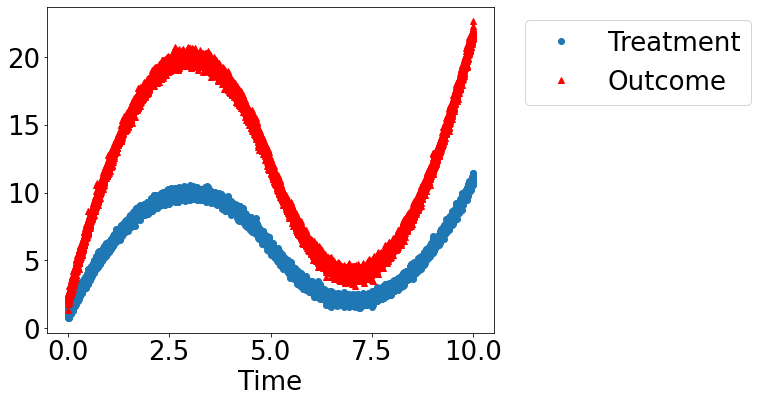

In [30]:
from dowhy import plotter
plotter.plot_treatment_outcome(df[data_dict["treatment_name"]], df[data_dict["outcome_name"]],
                             df[data_dict["time_val"]])

In [31]:
from dowhy import CausalModel
model= CausalModel(
        data=df,
        treatment=data_dict["treatment_name"],
        outcome=data_dict["outcome_name"],
        common_causes=data_dict["common_causes_names"],
        instruments=data_dict["instrument_names"])
model.view_model(layout="dot")

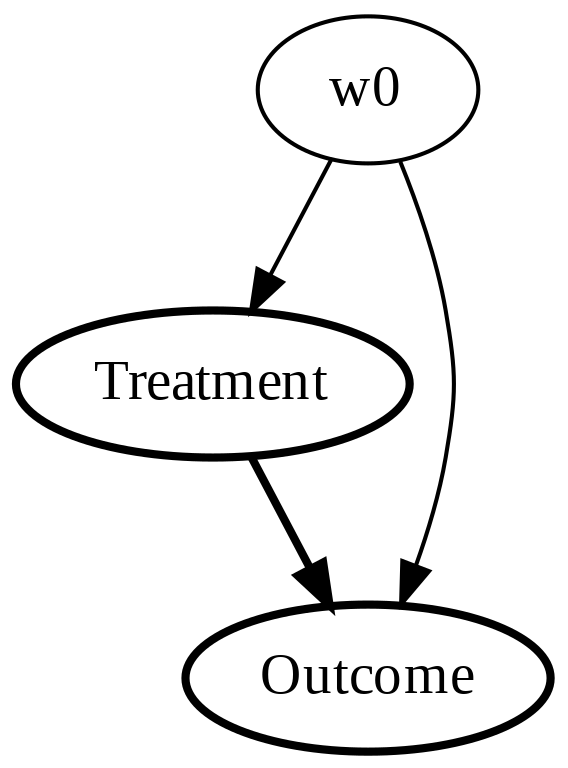

In [32]:
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

In [33]:
# backdoor - adjuestment 를 이용해서 추정하자.
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                               
────────────(Expectation(Outcome|w0))
d[Treatment]                         
Estimand assumption 1, Unconfoundedness: If U→{Treatment} and U→Outcome then P(Outcome|Treatment,w0,U) = P(Outcome|Treatment,w0)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [34]:
# linear regression 을 이용해서 effect 추정
estimate = model.estimate_effect(identified_estimand,method_name="backdoor.linear_regression")
print("Causal Estimate is " + str(estimate.value))

linear_regression
{'control_value': 0, 'treatment_value': 1, 'test_significance': None, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
Causal Estimate is 0.9730123714337058


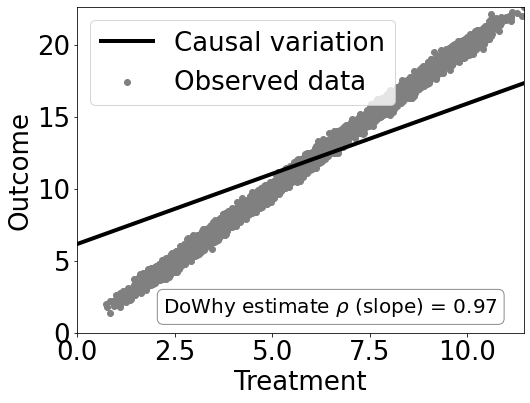

In [35]:
# Plot Slope of line between treamtent and outcome =causal effect
dowhy.plotter.plot_causal_effect(estimate, df[data_dict["treatment_name"]], df[data_dict["outcome_name"]])


In [36]:
# Checking if the estimate is correct

print("DoWhy estimate is " + str(estimate.value))
print ("Actual true causal effect was {0}".format(rvar))

DoWhy estimate is 0.9730123714337058
Actual true causal effect was 1


# Repute 하기

In [46]:
%%capture
res_random=model.refute_estimate(identified_estimand, estimate, method_name="random_common_cause")

In [47]:
print(res_random)

Refute: Add a random common cause
Estimated effect:0.9730123714337058
New effect:0.9730098190179508
p value:0.94



In [44]:
%%capture
res_placebo=model.refute_estimate(identified_estimand, estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute")

In [45]:
print(res_placebo)

Refute: Use a Placebo Treatment
Estimated effect:0.9730123714337058
New effect:-0.00013071728786190562
p value:0.8200000000000001



In [48]:
%%capture
res_subset=model.refute_estimate(identified_estimand, estimate,
        method_name="data_subset_refuter", subset_fraction=0.9)

In [49]:
print(res_subset)

Refute: Use a subset of data
Estimated effect:0.9730123714337058
New effect:0.973437930593189
p value:0.92

